In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from os import path

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import umap

In [3]:
DATA_DIR = "../../data/"

In [4]:
chen_data = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_data.csv"), index_col=0)
chen_data.rename({"Antibody_ID": "Ab_ID"}, axis=1, inplace=True)
chen_data.head(5)

,Ab_ID,heavy,light,Y
0,12e8,EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLE...,DIVMTQSQKFMSTSVGDRVSITCKASQNVGTAVAWYQQKPGQSPKL...,0
1,15c8,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0
2,1a0q,EVQLQESDAELVKPGASVKISCKASGYTFTDHVIHWVKQKPEQGLE...,DIELTQSPSSLSASLGGKVTITCKASQDIKKYIGWYQHKPGKQPRL...,1
3,1a14,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,0
4,1a2y,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,0


In [5]:
y_data = chen_data["Y"]

In [6]:
filtered_chen = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/filtered_chen_data.csv"), index_col=0)
filtered_chen.rename({"Antibody_ID": "Ab_ID"}, axis=1, inplace=True)
filtered_chen.head(5)

,Ab_ID,heavy,light,Y,cdrh3_length
0,12e8,EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLE...,DIVMTQSQKFMSTSVGDRVSITCKASQNVGTAVAWYQQKPGQSPKL...,0,13
1,15c8,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0,12
2,1a0q,EVQLQESDAELVKPGASVKISCKASGYTFTDHVIHWVKQKPEQGLE...,DIELTQSPSSLSASLGGKVTITCKASQDIKKYIGWYQHKPGKQPRL...,1,12
3,1a14,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,0,15
4,1a2y,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,0,10


In [7]:
chen_data["length"] = chen_data["heavy"].str.len() + chen_data["light"].str.len()

In [28]:
sabdab = pd.read_csv(path.join(DATA_DIR, "sabdab_summary_filtered.tsv"), sep="\t")
sabdab.head()

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid,HLchain,Hchain_fa,Lchain_fa
0,6igu,H,L,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,2019-10-09,...,IGKV1,Kappa,None,None,None,None,None,HL,6igu_H_VH.fa,6igu_L_VL.fa
1,6u1t,H,L,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,2019-10-09,...,IGKV12,Kappa,None,None,None,None,None,HL,6u1t_H_VH.fa,6u1t_L_VL.fa
2,4o51,B,A,0,N,peptide,NaN,ides hinge peptide,IMMUNE SYSTEM,2014-03-26,...,IGKV1,Kappa,None,None,None,None,None,BA,4o51_B_VH.fa,4o51_A_VL.fa
3,5w08,K,L,0,C,protein,NaN,hemagglutinin ha1,VIRAL PROTEIN/IMMUNE SYSTEM,2018-02-14,...,IGLV2,Lambda,None,None,None,None,None,KL,5w08_K_VH.fa,5w08_L_VL.fa
4,5i1e,H,L,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,2016-06-08,...,IGKV1,Kappa,None,None,None,None,None,HL,5i1e_H_VH.fa,5i1e_L_VL.fa


# Functions for projection

## PCA

In [9]:
def calculate_pca(
    x, components, plot=True
):
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(x)
    
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum = np.cumsum(exp_var_pca)
    
    if plot:
        plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
        plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()
    
    return X_pca

## t-SNE

In [10]:
def calculate_tsne(
    x, components, perplexity, n_iter=300, metric="euclidean"
):
    tsne = TSNE(n_components=components, verbose=1, perplexity=perplexity, n_iter=n_iter, metric=metric)
    X_embedded = tsne.fit_transform(x)
    
    return X_embedded
    

## UMAP

In [11]:
def calculate_umap(x, n_neighbors, min_dist, n_components=2, metric="euclidean"):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    embedding = reducer.fit_transform(x)
    return embedding

## Plot

In [12]:
def plot_transformed(x_pc, y, comp_to_plot=[0,1], title=None, palette=['#1f76b4','orange'], name=None):
    df = pd.DataFrame()
    df['x'] = x_pc[:,comp_to_plot[0]]
    df['y'] = x_pc[:,comp_to_plot[1]]
    df["label"] = y
    plt.figure(figsize=(16,10))
    ax = sns.scatterplot(
        x="x", y="y",
        hue="label",
        data=df,
        #legend="full",
        alpha=0.6,
        palette=palette
    )
    if title:
        plt.title(title, fontsize=20)
    if name:
        plt.savefig(path.join(DATA_DIR, name))
    plt.show()

# BERT embeddings

In [10]:
bert_data = pd.read_feather(path.join(DATA_DIR, "chen/embeddings/bert/bert_chen_embeddings.ftr"))
bert_data = bert_data.merge(chen_data[["Ab_ID", "Y"]], how="outer", on="Ab_ID")
bert_data.head()

,Ab_ID,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,Y
0,12e8,0.000388,-0.023631,0.008127,-0.042201,0.069842,-0.020211,0.009360,-0.093598,-0.015777,...,-0.017396,-0.025206,0.006201,0.003746,0.038917,-0.032526,-0.039207,-0.014133,-0.013472,0
1,15c8,-0.007020,-0.024430,0.014849,-0.031923,0.054462,-0.025220,0.007521,-0.098703,-0.016063,...,0.021122,-0.044553,-0.009425,-0.004844,0.044911,-0.022525,-0.019677,-0.013022,-0.049844,0
2,1a0q,-0.017142,-0.008645,0.008613,-0.046730,0.061336,-0.017951,0.020446,-0.108641,0.002343,...,-0.005492,-0.037837,-0.009891,-0.018668,0.045293,-0.042225,-0.015849,-0.002904,-0.023377,1
3,1a14,-0.016770,-0.016028,0.005558,-0.022389,0.048435,-0.029777,0.005205,-0.091042,0.002346,...,0.005187,-0.027305,0.012193,0.013407,0.019745,-0.029758,-0.021011,0.000632,-0.014885,0
4,1a2y,0.022052,-0.024678,0.013147,-0.041079,0.054560,-0.009407,-0.007112,-0.076221,0.010534,...,-0.015750,-0.031617,-0.013962,-0.021564,0.045667,-0.028034,-0.023921,-0.020638,-0.019502,0


## PCA

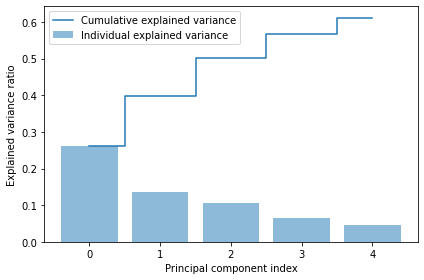

In [29]:
bert_tra = calculate_pca(bert_data.drop(["Y", "Ab_ID"], axis=1), components=5)

### Components 1 and 2

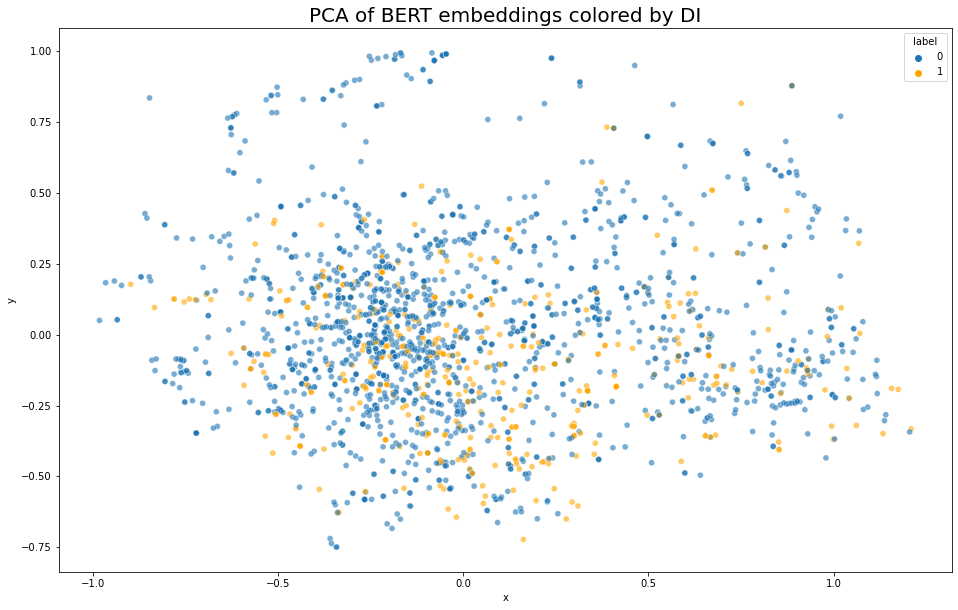

In [25]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "PCA of BERT embeddings colored by DI")

### Components 2 and 3

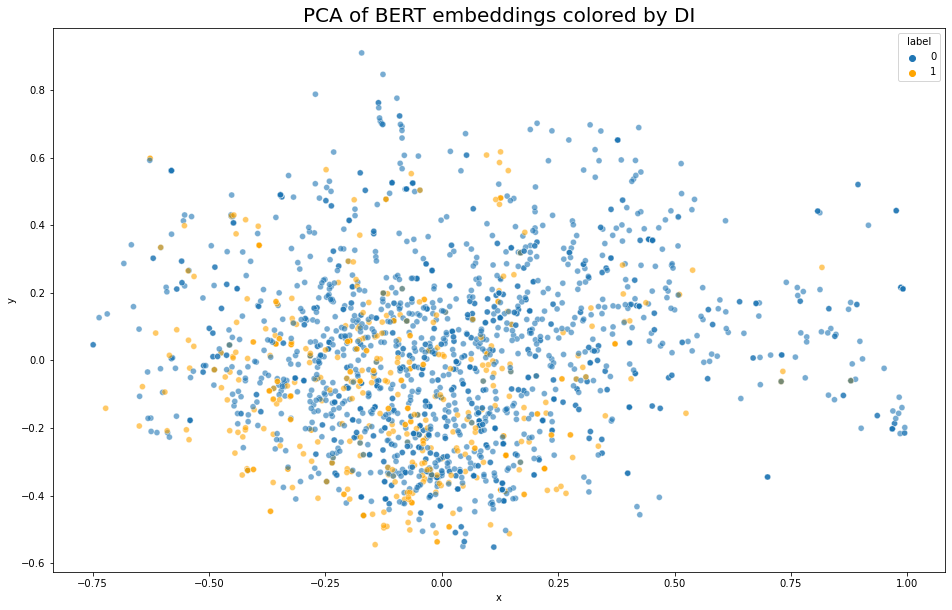

In [28]:
plot_transformed(bert_tra, bert_data["Y"], [1,2], "PCA of BERT embeddings colored by DI")

## t-SNE

In [39]:
bert_tra = calculate_tsne(bert_data.drop(["Y", "Ab_ID"], axis=1), components=3, perplexity=8)

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 25 nearest neighbors...
[t-SNE] Indexed 2409 samples in 0.003s...
[t-SNE] Computed neighbors for 2409 samples in 0.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2409
[t-SNE] Computed conditional probabilities for sample 2000 / 2409
[t-SNE] Computed conditional probabilities for sample 2409 / 2409
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.262283
[t-SNE] KL divergence after 300 iterations: 1.233149


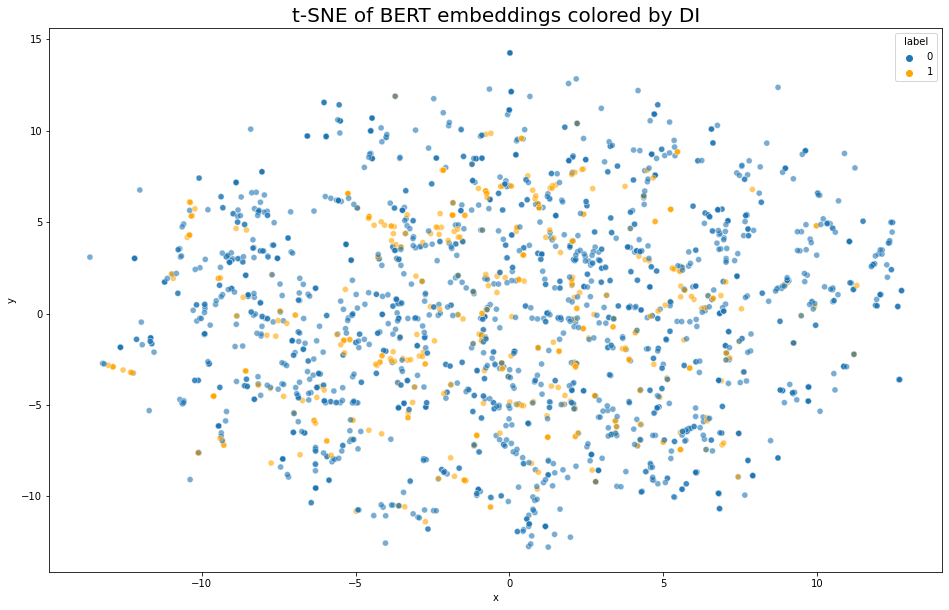

In [40]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "t-SNE of BERT embeddings colored by DI")

In [41]:
bert_tra = calculate_tsne(bert_data.drop(["Y", "Ab_ID"], axis=1), components=3, perplexity=40, n_iter=600)

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2409 samples in 0.006s...
[t-SNE] Computed neighbors for 2409 samples in 0.621s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2409
[t-SNE] Computed conditional probabilities for sample 2000 / 2409
[t-SNE] Computed conditional probabilities for sample 2409 / 2409
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.881592
[t-SNE] KL divergence after 600 iterations: 0.614096


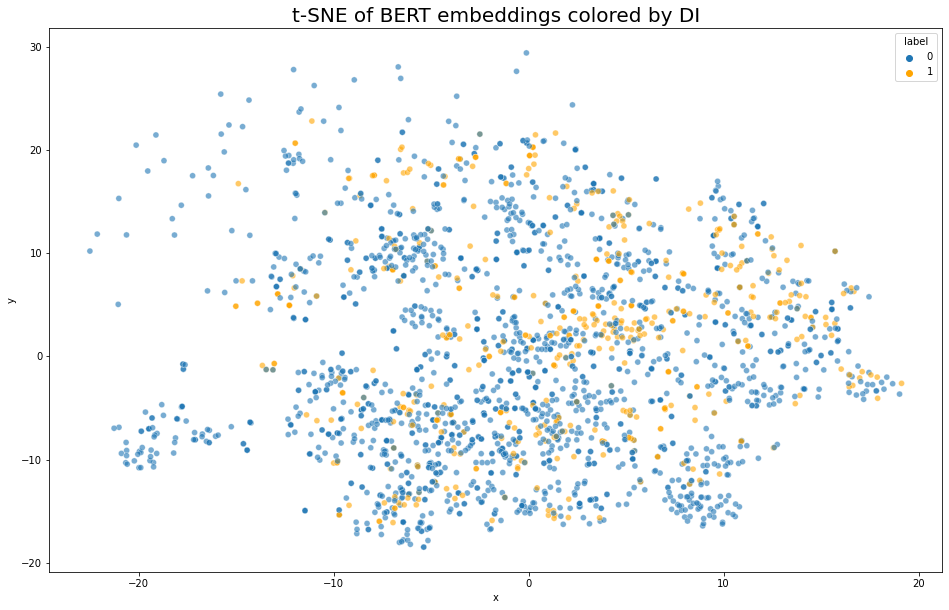

In [42]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "t-SNE of BERT embeddings colored by DI")

## UMAP

In [22]:
bert_tra = calculate_umap(bert_data.drop(["Y", "Ab_ID"], axis=1), n_neighbors=8, min_dist=0.1)

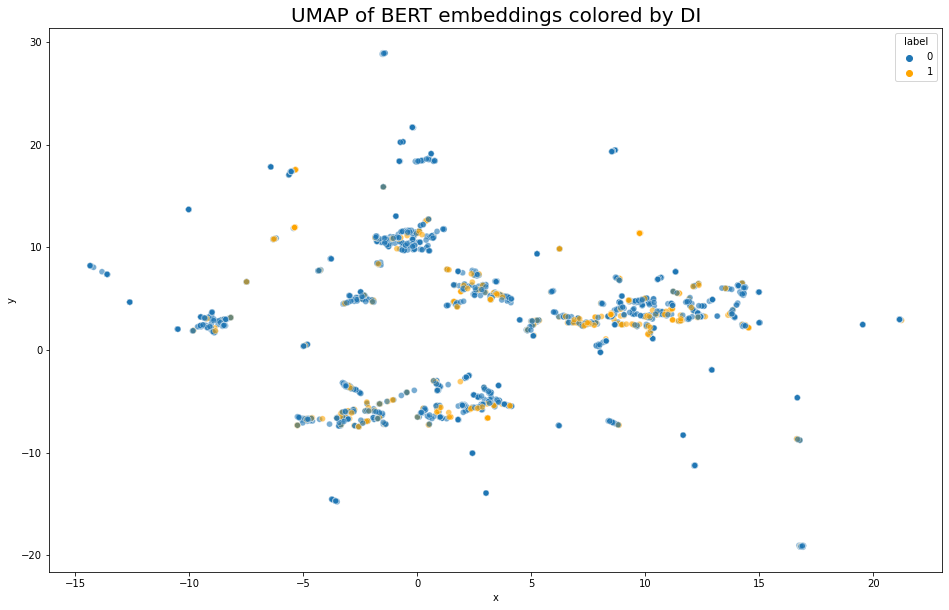

In [23]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "UMAP of BERT embeddings colored by DI")

In [24]:
bert_tra = calculate_umap(bert_data.drop(["Y", "Ab_ID"], axis=1), n_neighbors=40, min_dist=0.2)

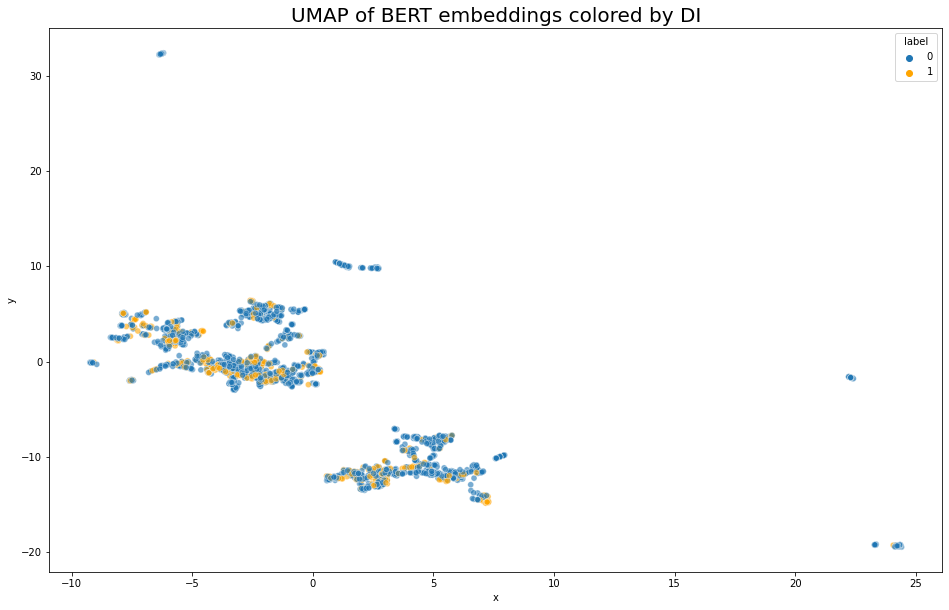

In [25]:
plot_transformed(bert_tra, bert_data["Y"], [0, 1], "UMAP of BERT embeddings colored by DI")

In [26]:
tap_bert = pd.read_feather(path.join(DATA_DIR, "tap/embeddings/bert/bert_tap_embeddings.ftr"))
tap_bert.head()

,Ab_ID,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,Abagovomab,-0.004248,-0.024501,-0.011330,-0.027170,0.062747,-0.024793,0.009313,-0.083316,-0.005339,...,-0.008674,-0.002387,-0.021563,0.001087,-0.020986,0.047104,-0.038736,-0.021780,-0.022153,-0.024539
1,Abituzumab,0.006593,-0.013591,-0.008454,-0.043601,0.065095,-0.016896,-0.001596,-0.090935,-0.002940,...,0.000486,-0.013063,-0.021852,-0.003531,-0.024620,0.027387,-0.041001,-0.025708,-0.016437,-0.034342
2,Abrilumab,0.019445,-0.002642,-0.011395,-0.058757,0.060623,-0.015046,0.006317,-0.083772,-0.006775,...,0.005834,-0.017189,-0.014557,0.003359,-0.035368,0.020287,-0.033941,-0.023549,-0.008720,-0.044038
3,Actoxumab,-0.006365,-0.043729,0.005978,-0.025613,0.067748,-0.009542,0.017723,-0.096801,-0.007752,...,-0.000024,-0.012986,-0.019753,-0.004326,-0.044124,0.019544,-0.039559,-0.015679,-0.008837,-0.043877
4,Adalimumab,-0.012995,-0.035269,0.014127,-0.042136,0.080592,-0.012831,0.031889,-0.091308,-0.018166,...,-0.002067,-0.022957,-0.021145,-0.002762,-0.058199,0.026781,-0.046815,-0.010110,-0.008785,-0.041761


In [32]:
tap_bert["Ab_ID"] = tap_bert["Ab_ID"].str.lower()

# Jain

In [29]:
jain_results = pd.read_excel(path.join(DATA_DIR, "Jain/jain_results.xlsx"))
jain_results.drop(0, axis=0, inplace=True)
jain_results.head()

,Name,HEK Titer (mg/L),Fab Tm by DSF (°C),SGAC-SINS AS100 ((NH4)2SO4 mM),HIC Retention Time (Min)a,SMAC Retention Time (Min)a,Slope for Accelerated Stability,Poly-Specificity Reagent (PSR) SMP Score (0-1),Affinity-Capture Self-Interaction Nanoparticle Spectroscopy (AC-SINS) ∆λmax (nm) Average,CIC Retention Time (Min),CSI-BLI Delta Response (nm),ELISA,BVP ELISA
1,abituzumab,89.555458,75.5,900.0,9.227,8.725,0.05563,0.166666,1.458861,8.621,0.00,1.137375,2.720799
2,abrilumab,100.223196,71.0,900.0,9.413,8.699,0.02829,0.000000,-0.928526,8.384,-0.02,1.124624,1.818303
3,adalimumab,134.928638,71.0,900.0,8.816,8.672,0.05069,0.000000,1.062328,8.865,-0.01,1.075515,1.488186
4,alemtuzumab,144.653543,74.5,1000.0,8.769,8.672,0.06431,0.000000,-0.789199,8.514,-0.02,1.161491,1.464226
5,alirocumab,69.232345,71.5,900.0,9.036,8.681,0.02920,0.000000,1.230511,8.757,-0.01,1.196224,2.179700


In [36]:
thera_abs = jain_results[["Name", "HIC Retention Time (Min)a"]].merge(tap_bert, left_on="Name", right_on="Ab_ID")
thera_abs.drop("Name", axis=1, inplace=True)
thera_abs.head()

,HIC Retention Time (Min)a,Ab_ID,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,9.227,abituzumab,0.006593,-0.013591,-0.008454,-0.043601,0.065095,-0.016896,-0.001596,-0.090935,...,0.000486,-0.013063,-0.021852,-0.003531,-0.024620,0.027387,-0.041001,-0.025708,-0.016437,-0.034342
1,9.413,abrilumab,0.019445,-0.002642,-0.011395,-0.058757,0.060623,-0.015046,0.006317,-0.083772,...,0.005834,-0.017189,-0.014557,0.003359,-0.035368,0.020287,-0.033941,-0.023549,-0.008720,-0.044038
2,8.816,adalimumab,-0.012995,-0.035269,0.014127,-0.042136,0.080592,-0.012831,0.031889,-0.091308,...,-0.002067,-0.022957,-0.021145,-0.002762,-0.058199,0.026781,-0.046815,-0.010110,-0.008785,-0.041761
3,8.769,alemtuzumab,0.008921,-0.015691,0.000028,-0.036383,0.073180,-0.004192,0.010146,-0.077392,...,-0.002782,-0.015466,-0.020755,0.007428,-0.017236,0.034217,-0.043211,-0.023943,-0.005261,-0.023860
4,9.036,alirocumab,-0.012634,-0.043914,0.010695,-0.025280,0.082735,-0.007233,0.021435,-0.094274,...,0.003129,-0.004609,-0.033785,-0.001745,-0.036706,0.019747,-0.038604,-0.015006,0.001132,-0.040098


In [37]:
bert_tra = calculate_umap(thera_abs.drop( ["Ab_ID", "HIC Retention Time (Min)a"], axis=1), n_neighbors=8, min_dist=0.1)

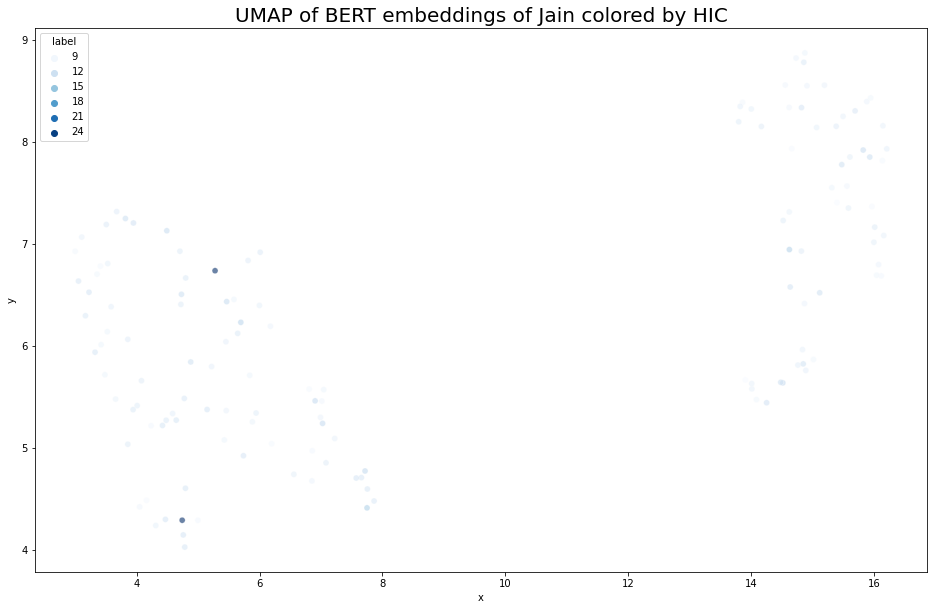

In [45]:
plot_transformed(
    bert_tra, thera_abs["HIC Retention Time (Min)a"], [0, 1], 
    "UMAP of BERT embeddings of Jain colored by HIC",
    palette='Blues'
)

# One-hot encoding

In [36]:
chen_data["length"] = chen_data["heavy"].str.len() + chen_data["light"].str.len()

In [37]:
onehot = pd.read_feather(path.join(DATA_DIR, "chen/onehot/chen_onehot.ftr"))
onehot = onehot.merge(chen_data[["Ab_ID", "Y", "length"]], how="inner", on="Ab_ID")
onehot.head()

,Ab_ID,1_-_x,1_A_x,1_C_x,1_D_x,1_E_x,1_F_x,1_G_x,1_H_x,1_I_x,...,127_P_y,127_Q_y,127_R_y,127_S_y,127_T_y,127_V_y,127_W_y,127_Y_y,Y,length
0,12e8,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,227
1,15c8,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,227
2,1a0q,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,225
3,1a14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,222
4,1a2y,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,223


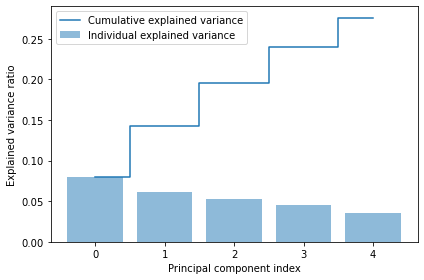

In [32]:
onehot_tra = calculate_pca(onehot.drop(["Y", "Ab_ID", "length"], axis=1), components=5)

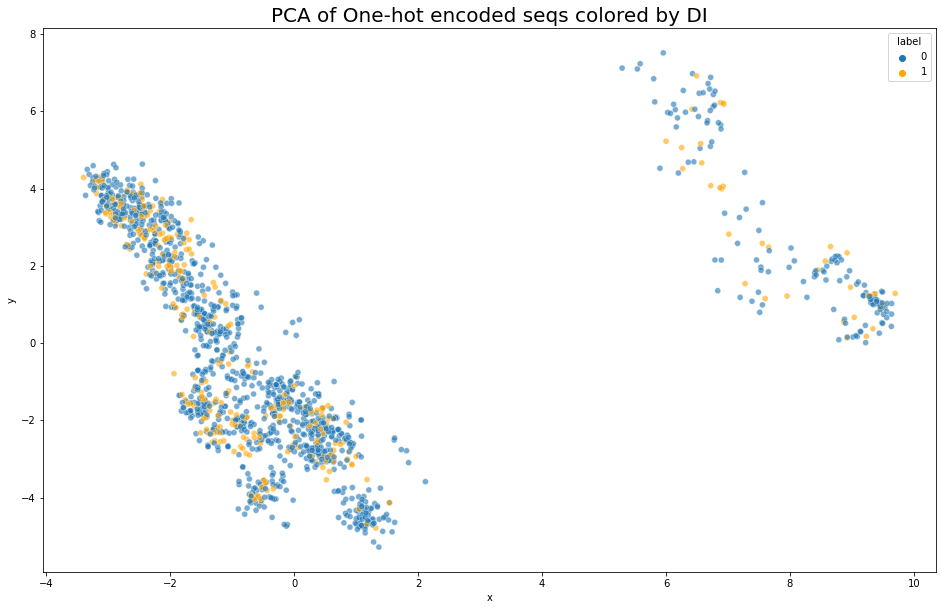

In [29]:
plot_transformed(onehot_tra, onehot["Y"], [0, 1], "PCA of One-hot encoded seqs colored by DI")

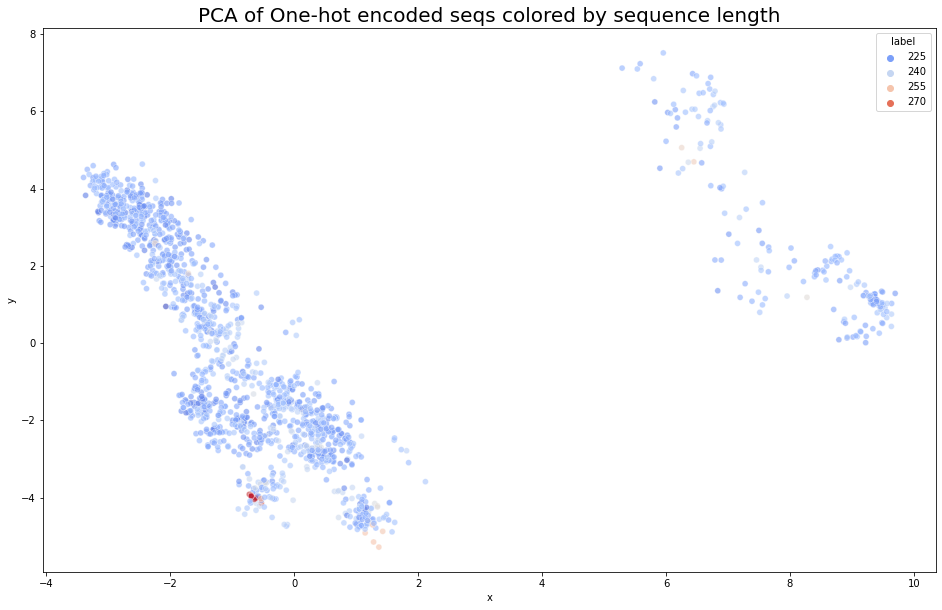

In [37]:
plot_transformed(onehot_tra, onehot["length"], [0, 1], "PCA of One-hot encoded seqs colored by sequence length", palette="coolwarm")

In [44]:
onehot_tra = calculate_tsne(onehot.drop(["Y", "Ab_ID", "length"], axis=1), components=3, perplexity=50)

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1573 samples in 0.010s...
[t-SNE] Computed neighbors for 1573 samples in 0.818s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1573
[t-SNE] Computed conditional probabilities for sample 1573 / 1573
[t-SNE] Mean sigma: 4.636284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.368332
[t-SNE] KL divergence after 300 iterations: 0.698034


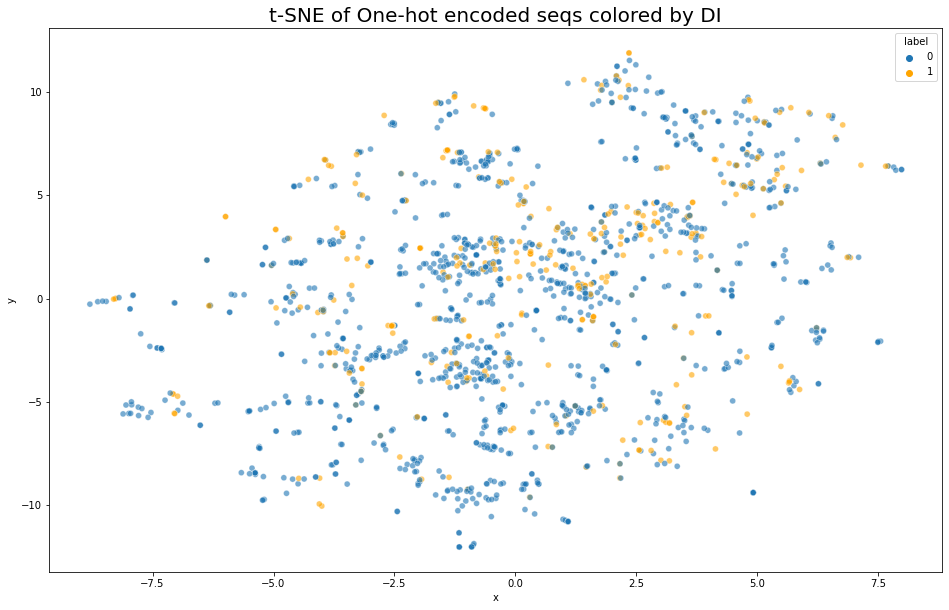

In [45]:
plot_transformed(onehot_tra, onehot["Y"], [0, 1], "t-SNE of One-hot encoded seqs colored by DI")

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1573 samples in 0.006s...
[t-SNE] Computed neighbors for 1573 samples in 0.818s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1573
[t-SNE] Computed conditional probabilities for sample 1573 / 1573
[t-SNE] Mean sigma: 3.880215
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.234589
[t-SNE] KL divergence after 600 iterations: 0.476152


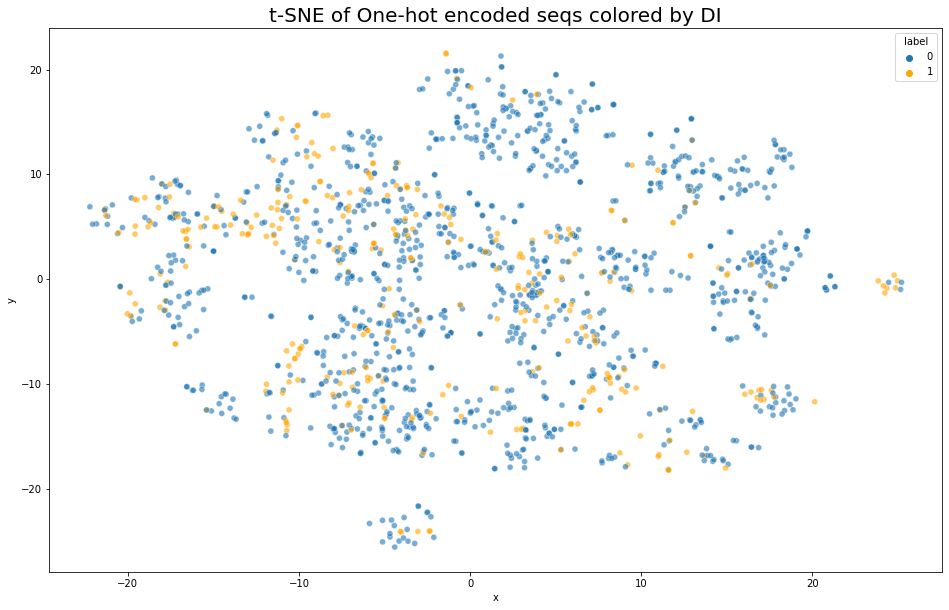

In [38]:
onehot_tra = calculate_tsne(onehot.drop(["Y", "Ab_ID", "length"], axis=1), components=3, perplexity=20, n_iter=600)
plot_transformed(onehot_tra, onehot["Y"], [0, 1], "t-SNE of One-hot encoded seqs colored by DI")#, name="images/tsne_onehot")

In [41]:
labels = onehot.merge(sabdab[["pdb", "heavy_subclass", "light_subclass"]], left_on="Ab_ID", right_on="pdb", how="left").drop("pdb", axis=1)
labels = labels[["Ab_ID", "heavy_subclass", "light_subclass"]].drop_duplicates("Ab_ID")

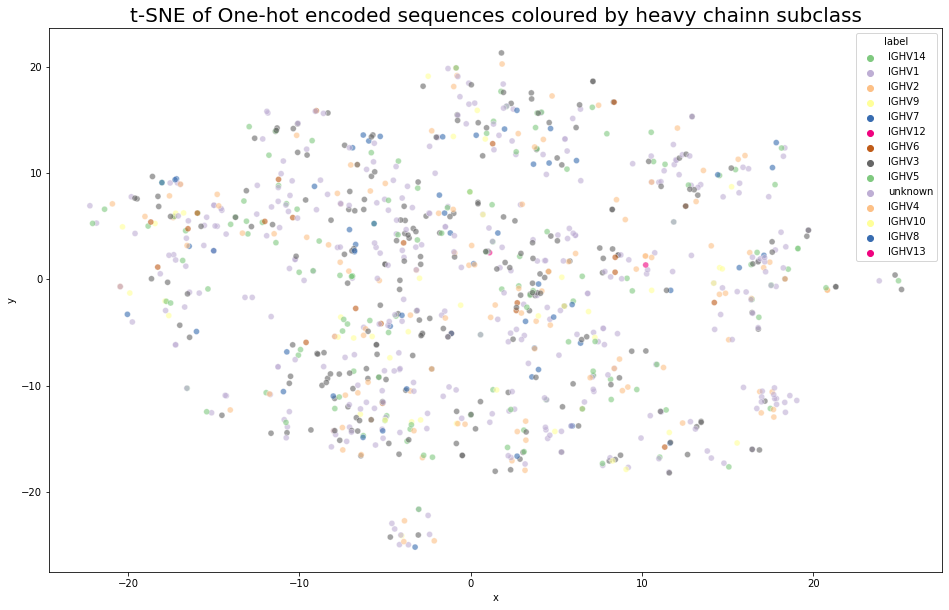

In [43]:
plot_transformed(onehot_tra, labels["heavy_subclass"], [0, 1], "t-SNE of One-hot encoded sequences coloured by heavy chainn subclass", palette="Accent")#, name="images/tsne_onehot")

In [46]:
onehot_tra = calculate_umap(onehot.drop(["Y", "Ab_ID"], axis=1), n_neighbors=8, min_dist=0.1)

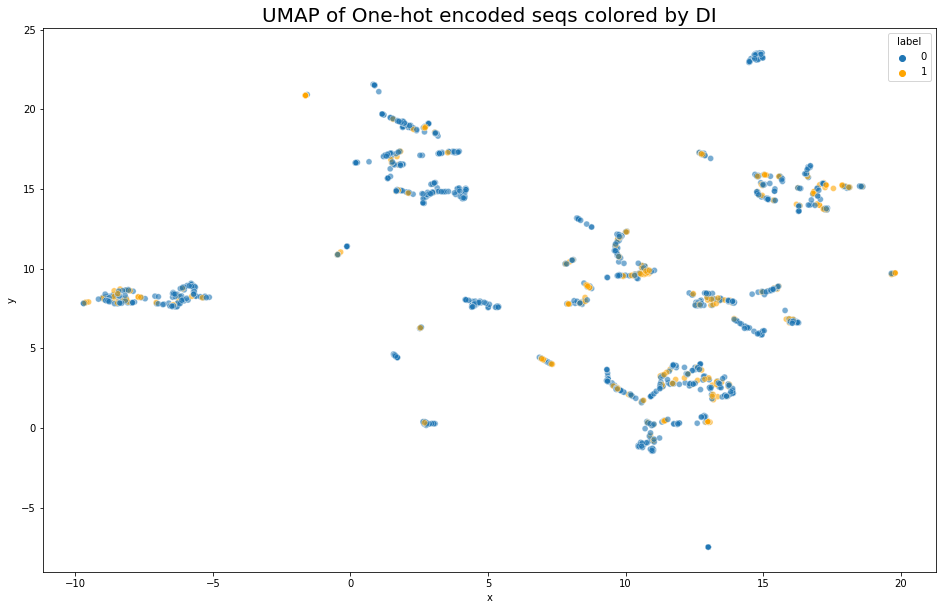

In [47]:
plot_transformed(onehot_tra, onehot["Y"], [0, 1], "UMAP of One-hot encoded seqs colored by DI")

# PyBioMed

In [29]:
pybiomed = pd.read_feather(path.join(DATA_DIR, "chen/pybiomed/X_data.ftr"))
pybiomed = pybiomed.merge(chen_data[["Ab_ID", "Y", "length"]], how="inner", on="Ab_ID")
pybiomed.head()

,Ab_ID,0,1,2,3,4,5,6,7,8,...,19752,19753,19754,19755,19756,19757,19758,19759,Y,length
0,12e8,7.500,3.333,2.500,5.833,1.667,5.833,5.833,9.167,1.667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,227
1,15c8,9.244,0.000,3.361,5.882,1.681,4.202,6.723,8.403,2.521,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,227
2,1a0q,5.882,1.681,3.361,5.042,1.681,5.882,5.042,9.244,1.681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,225
3,1a14,6.667,2.500,4.167,5.000,1.667,2.500,7.500,11.667,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,222
4,1a2y,3.448,5.172,4.310,6.034,1.724,2.586,6.034,10.345,0.862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,223


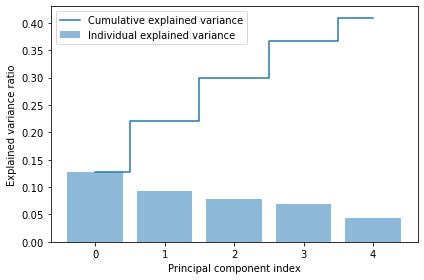

In [51]:
tra = calculate_pca(pybiomed.drop(["Y", "Ab_ID", "length"], axis=1), components=5)

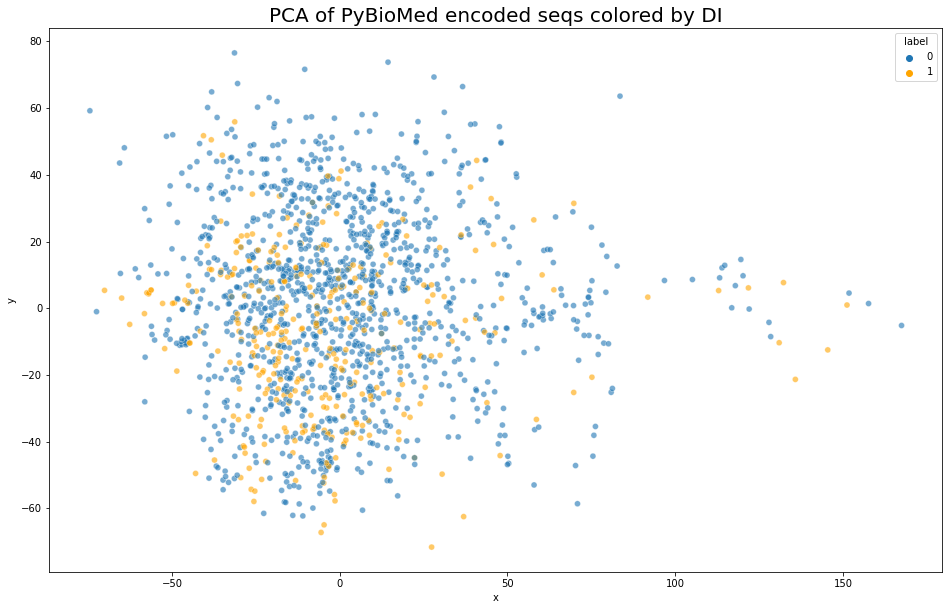

In [52]:
plot_transformed(tra, pybiomed["Y"], [0, 1], "PCA of PyBioMed encoded seqs colored by DI")

In [18]:
tra = calculate_tsne(pybiomed.drop(["Y", "Ab_ID", "length"], axis=1), components=3, perplexity=50)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1577 samples in 0.013s...
[t-SNE] Computed neighbors for 1577 samples in 1.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1577
[t-SNE] Computed conditional probabilities for sample 1577 / 1577
[t-SNE] Mean sigma: 19.617923
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.038574
[t-SNE] KL divergence after 300 iterations: 1.036917


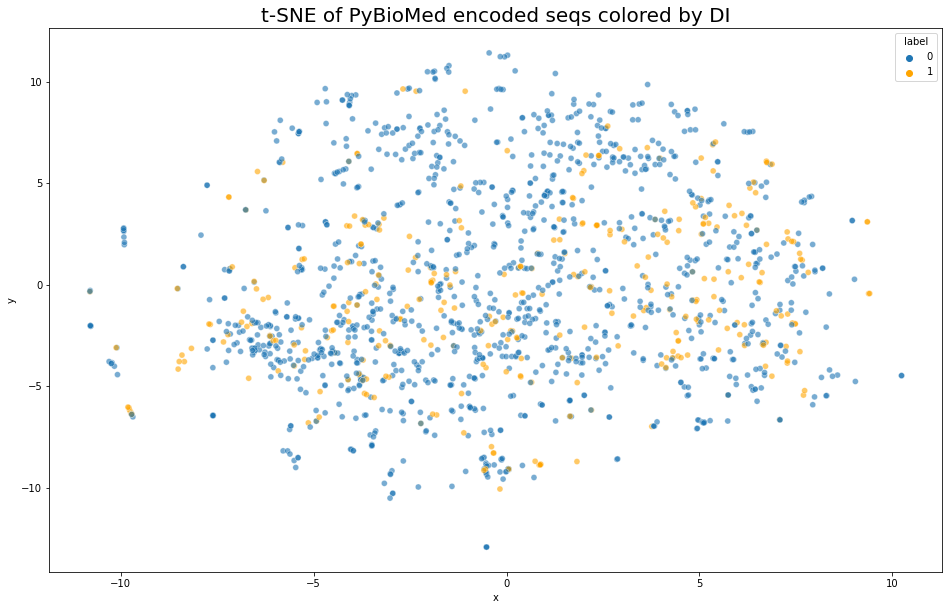

In [19]:
plot_transformed(tra, pybiomed["Y"], [0, 1], "t-SNE of PyBioMed encoded seqs colored by DI")

In [33]:
labels = pybiomed.merge(sabdab[["pdb", "heavy_subclass", "light_subclass"]], left_on="Ab_ID", right_on="pdb", how="left").drop("pdb", axis=1)
labels = labels[["Ab_ID", "heavy_subclass", "light_subclass"]].drop_duplicates("Ab_ID")
labels.head()

,Ab_ID,heavy_subclass,light_subclass
0,12e8,IGHV14,IGKV6
2,15c8,IGHV14,IGKV4
3,1a0q,IGHV1,IGKV19
4,1a14,IGHV1,IGKV10
5,1a2y,IGHV2,IGKV12


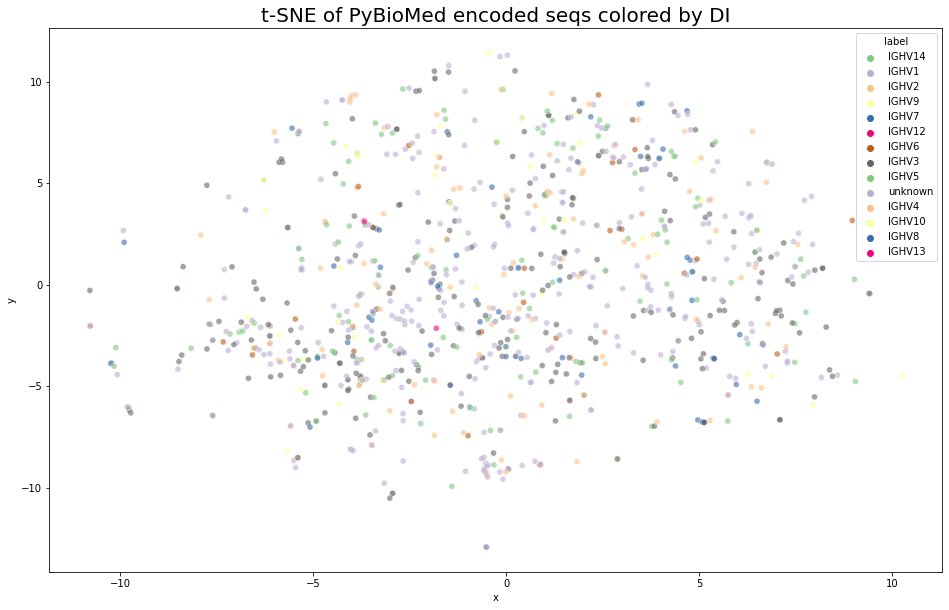

In [35]:
plot_transformed(tra, labels["heavy_subclass"], [0, 1], "t-SNE of PyBioMed encoded seqs colored by DI", palette="Accent")

In [55]:
tra = calculate_umap(pybiomed.drop(["Y", "Ab_ID"], axis=1), n_neighbors=8, min_dist=0.1)

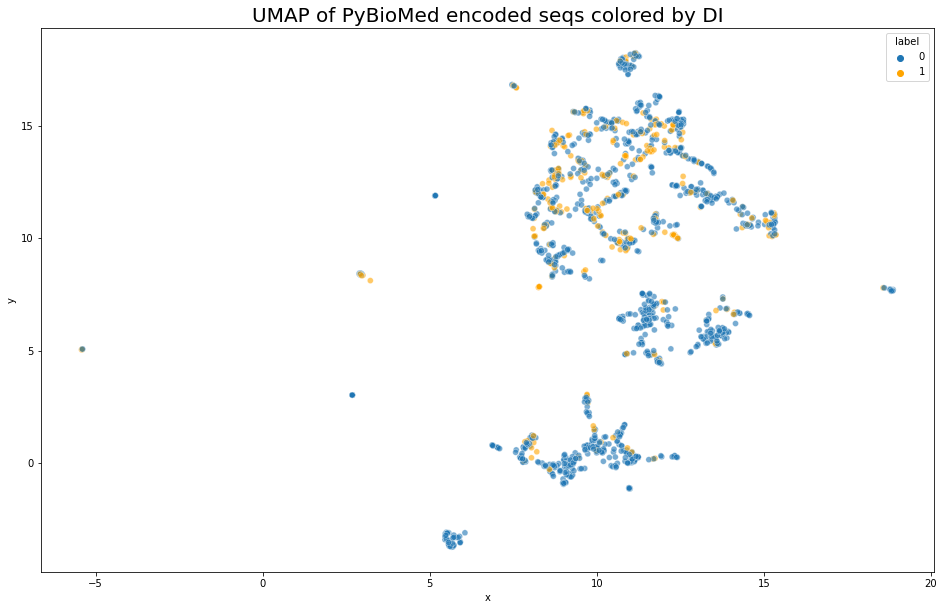

In [56]:
plot_transformed(tra, pybiomed["Y"], [0, 1], "UMAP of PyBioMed encoded seqs colored by DI")

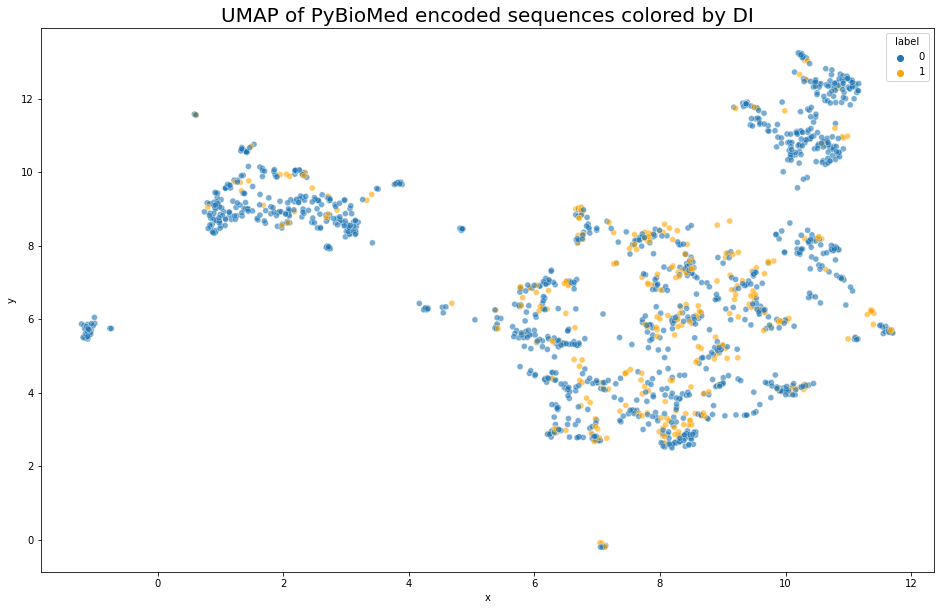

In [72]:
#tra = calculate_umap(pybiomed.drop(["Y", "Ab_ID"], axis=1), n_neighbors=20, min_dist=0.1)
plot_transformed(tra, pybiomed["Y"], [0, 1], "UMAP of PyBioMed encoded sequences colored by DI", name="images/umap_pybiomed.png")

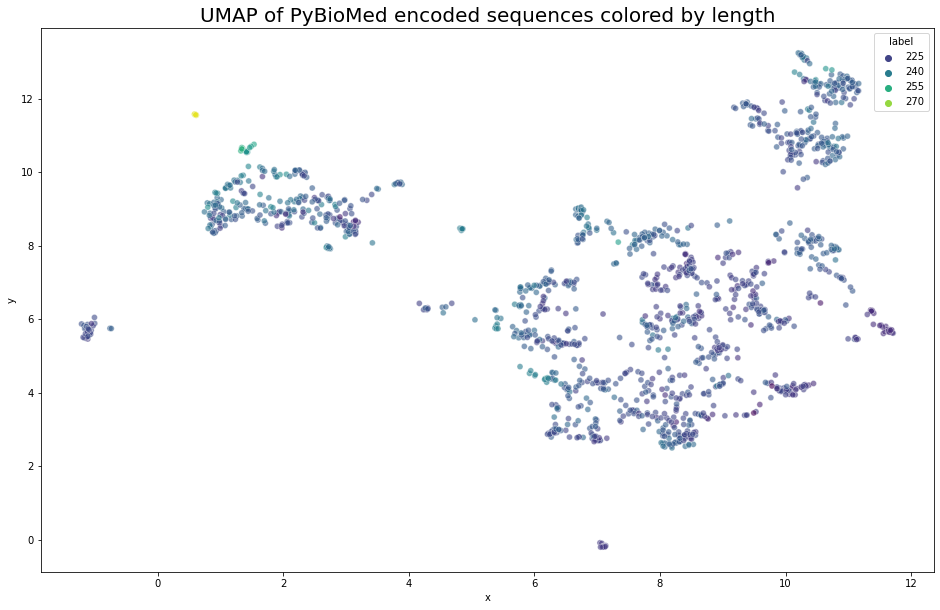

In [73]:
plot_transformed(tra, pybiomed["length"], [0, 1], "UMAP of PyBioMed encoded sequences colored by length", palette="viridis", name="images/umap_pybiomed_by_len.png")

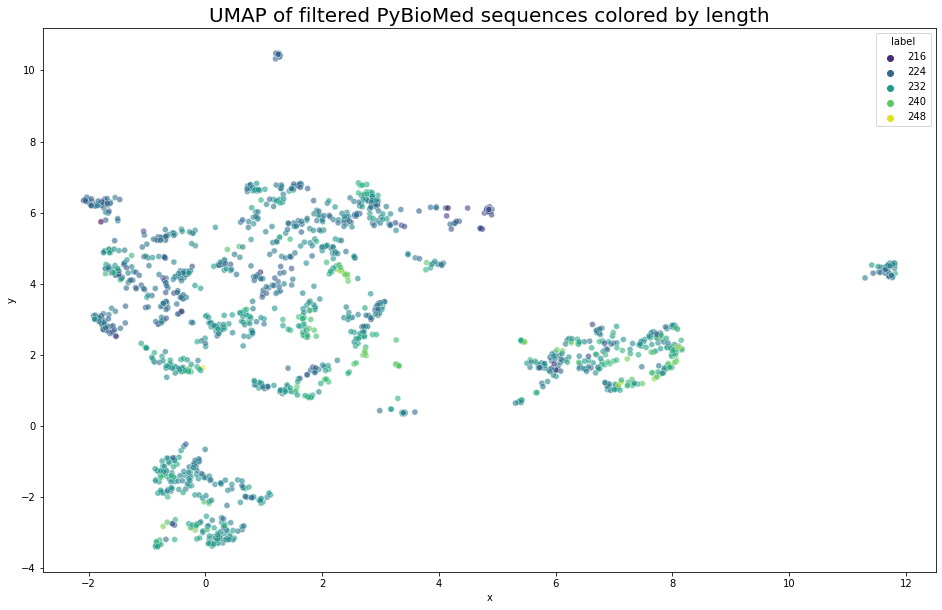

In [85]:
#tra = calculate_umap(pybiomed.merge(filtered_chen["Ab_ID"], on="Ab_ID").drop(["Y", "Ab_ID"], axis=1), n_neighbors=20, min_dist=0.1)
plot_transformed(tra, pybiomed.merge(filtered_chen["Ab_ID"], on="Ab_ID")["length"], [0, 1], "UMAP of filtered PyBioMed sequences colored by length", name="images/umap_pybiomed_by_len_filt.png", palette="viridis")

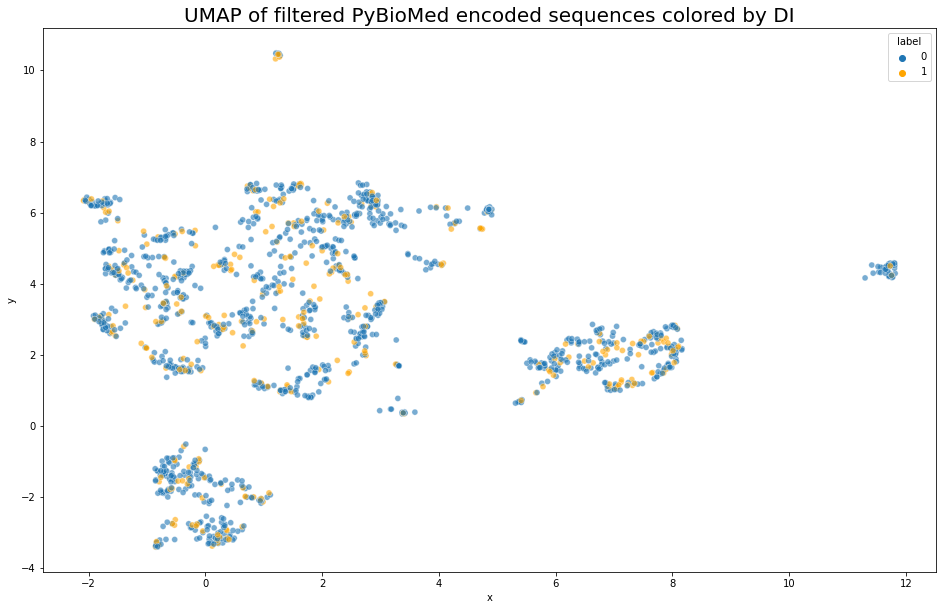

In [87]:
plot_transformed(tra, pybiomed["Y"], [0, 1], "UMAP of filtered PyBioMed encoded sequences colored by DI", name="images/umap_pybiomed_filt.png")

In [82]:
119+138

257